In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

from google.colab import files
files.upload()



Saving NSE-Tata-Global-Beverages-Limited.csv to NSE-Tata-Global-Beverages-Limited (1).csv


{'NSE-Tata-Global-Beverages-Limited.csv': b'Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)\n2018-10-08,208.0,222.25,206.85,216.0,215.15,4642146.0,10062.83\n2018-10-05,217.0,218.6,205.9,210.25,209.2,3519515.0,7407.06\n2018-10-04,223.5,227.8,216.15,217.25,218.2,1728786.0,3815.79\n2018-10-03,230.0,237.5,225.75,226.45,227.6,1708590.0,3960.27\n2018-10-01,234.55,234.6,221.05,230.3,230.9,1534749.0,3486.05\n2018-09-28,234.05,235.95,230.2,233.5,233.75,3069914.0,7162.35\n2018-09-27,234.55,236.8,231.1,233.8,233.25,5082859.0,11859.95\n2018-09-26,240.0,240.0,232.5,235.0,234.25,2240909.0,5248.6\n2018-09-25,233.3,236.75,232.0,236.25,236.1,2349368.0,5503.9\n2018-09-24,233.55,239.2,230.75,234.0,233.3,3423509.0,7999.55\n2018-09-21,235.0,237.0,227.95,233.75,234.6,5395319.0,12589.59\n2018-09-19,235.95,237.2,233.45,234.6,234.9,1362058.0,3202.78\n2018-09-18,237.9,239.25,233.5,235.5,235.05,2614794.0,6163.7\n2018-09-17,233.15,238.0,230.25,236.4,236.6,3170894.0,7445.41\n2018-09-14,223.45,23

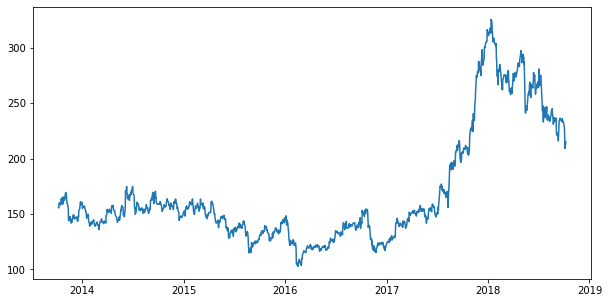

In [41]:
df=pd.read_csv("NSE-Tata-Global-Beverages-Limited.csv")
df.head()

df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(10,5))
plt.plot(df["Close"],label='Close Price history')


In [43]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]
    

new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values

train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))




Epoch 1/10
58/58 - 6s - loss: 0.0047
Epoch 2/10
58/58 - 3s - loss: 0.0013
Epoch 3/10
58/58 - 3s - loss: 0.0011
Epoch 4/10
58/58 - 3s - loss: 0.0010
Epoch 5/10
58/58 - 3s - loss: 0.0010
Epoch 6/10
58/58 - 3s - loss: 9.4772e-04
Epoch 7/10
58/58 - 3s - loss: 8.7004e-04
Epoch 8/10
58/58 - 3s - loss: 8.2686e-04
Epoch 9/10
58/58 - 3s - loss: 7.9521e-04
Epoch 10/10
58/58 - 3s - loss: 8.2416e-04


In [ ]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))




lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=10,batch_size=16,verbose=2)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


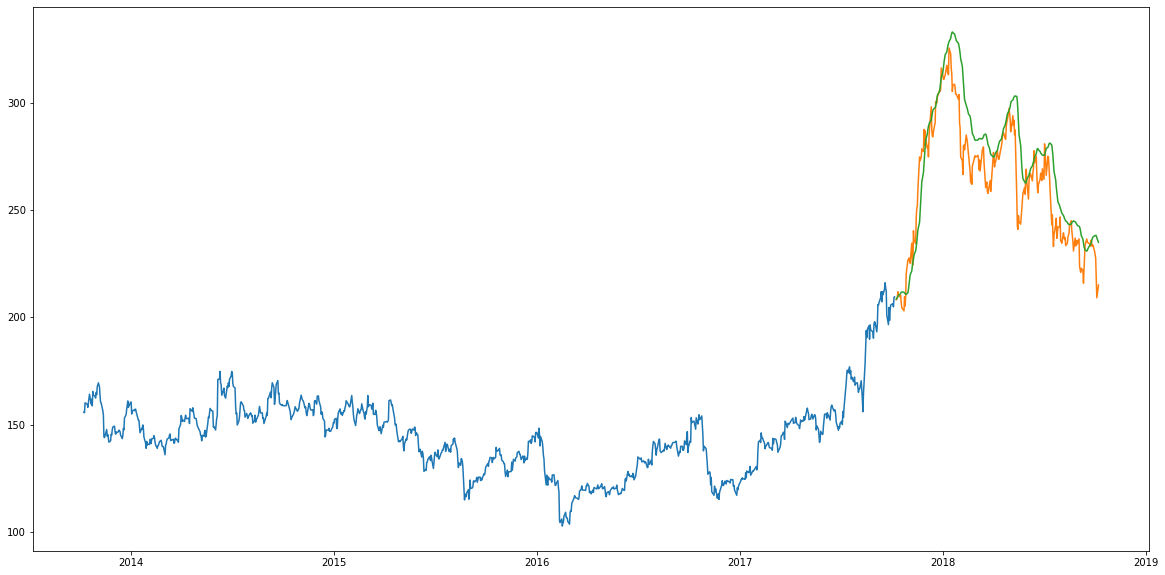

In [40]:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)


X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

closing_price=lstm_model.predict(X_test)
closing_price=scaler.inverse_transform(closing_price)

lstm_model.save("saved_lstm_model.h5")

train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])